In [1]:
import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.models import Model
import sys
import copy
import requests
from io import BytesIO

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


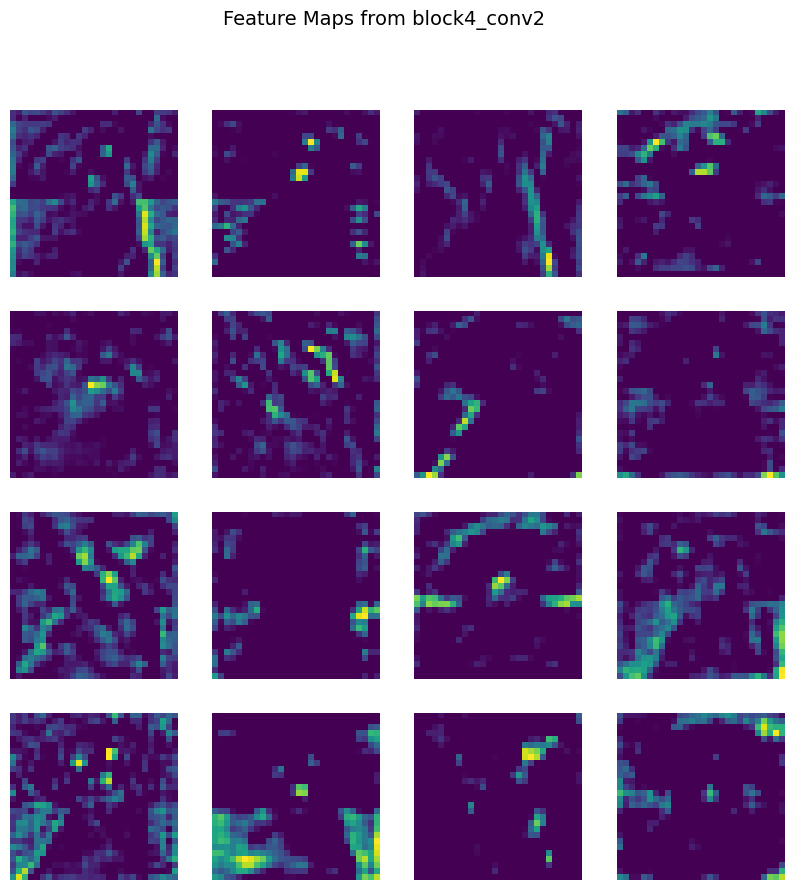

In [22]:
# Code to Visualize Feature Maps

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

# Function to preprocess the image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = vgg19.preprocess_input(img)  # Normalize for VGG19
    return img

# Function to display feature maps
def visualize_feature_maps(model, img_path, layer_name):
    img = load_and_preprocess_image(img_path)

    # Extracting the outputs from the chosen layer
    intermediate_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    feature_maps = intermediate_model.predict(img)

    # Reshape and visualize feature maps
    num_maps = min(16, feature_maps.shape[-1])  # Show up to 16 feature maps
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))

    for i, ax in enumerate(axes.flat):
        if i < num_maps:
            ax.imshow(feature_maps[0, :, :, i], cmap='viridis')
            ax.axis('off')

    plt.suptitle(f"Feature Maps from {layer_name}", fontsize=14)
    plt.show()

# Load pre-trained VGG19 model
base_model = vgg19.VGG19(weights='imagenet', include_top=False)

# Image path (replace with your own image)
image_path = "/content/Golden-Retriever.jpg"

# Choose a content-related layer (e.g., block4_conv2)
visualize_feature_maps(base_model, image_path, "block4_conv2")
